<a href="https://colab.research.google.com/github/vinothkumarsubbu/auth0-python/blob/master/Scaler_BC_Netflix_Feb_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Netflix Business case


### Basic Setup

In [445]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
from wordcloud import WordCloud, STOPWORDS

In [358]:
!wget https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv -O netflix.csv

--2023-02-21 20:13:28--  https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv
Resolving d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)... 99.84.170.176, 99.84.170.67, 99.84.170.112, ...
Connecting to d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)|99.84.170.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3399671 (3.2M) [text/plain]
Saving to: ‘netflix.csv’

netflix.csv         100%[===================>]   3.24M  --.-KB/s    in 0.08s   

2023-02-21 20:13:28 (41.9 MB/s) - ‘netflix.csv’ saved [3399671/3399671]



In [359]:
df = pd.read_csv("netflix.csv")

In [360]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [361]:
#To the information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [362]:
# Data Patch found during the anlaysis
df.loc[(df["rating"].str.contains(" min", na=False)), 'duration'] = df.loc[(df["rating"].str.contains(" min", na=False)), 'rating']
df.loc[(df["rating"].str.contains(" min", na=False)), 'rating'] = np.NaN

In [363]:
# To count the missing values
df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [364]:
def find_type_of_fields(df, seperator=','):
  fields = []
  for column in df.columns:
    fields.append({column:(df[column].astype(str).str.contains(seperator) == True).sum()})
  return fields

In [365]:
fields = find_type_of_fields(df)
print(*fields, sep = "\n")

{'show_id': 0}
{'type': 0}
{'title': 138}
{'director': 614}
{'cast': 7101}
{'country': 1320}
{'date_added': 8797}
{'release_year': 0}
{'rating': 0}
{'duration': 0}
{'listed_in': 6787}
{'description': 6448}


In [366]:
#Exclude Title(may contain), Description(can contain), date(based on date format) as its expected to contain the comma. Split other columns


In [367]:
df["date_added"] = pd.to_datetime(df["date_added"])
df["date_added_year"] = pd.to_numeric(df["date_added"].dt.strftime('%Y'))
df["date_added_month"] = pd.to_numeric(df["date_added"].dt.strftime('%m'))
df["date_added_date"] = pd.to_numeric(df["date_added"].dt.strftime('%d'))

In [368]:
def split_column_return_df(data_frame, column_name, index_column='title'):
  list_values=data_frame[column_name].apply(lambda x:str(x).split(', ')).tolist()
  df=pd.DataFrame(list_values,index=data_frame[index_column])
  df=df.stack()
  df=pd.DataFrame(df)
  df.reset_index(inplace=True)
  df=df[[index_column,0]]
  df.columns=[index_column,column_name]
  return df

In [369]:
director_df=split_column_return_df(df, 'director')

In [370]:
director_df.head(20)

,title,director
0,Dick Johnson Is Dead,Kirsten Johnson
1,Blood & Water,nan
2,Ganglands,Julien Leclercq
3,Jailbirds New Orleans,nan
4,Kota Factory,nan
5,Midnight Mass,Mike Flanagan
6,My Little Pony: A New Generation,Robert Cullen
7,My Little Pony: A New Generation,José Luis Ucha
8,Sankofa,Haile Gerima
9,The Great British Baking Show,Andy Devonshire


In [371]:
cast_df=split_column_return_df(df, 'cast')
cast_df.head(20)

,title,cast
0,Dick Johnson Is Dead,nan
1,Blood & Water,Ama Qamata
2,Blood & Water,Khosi Ngema
3,Blood & Water,Gail Mabalane
4,Blood & Water,Thabang Molaba
5,Blood & Water,Dillon Windvogel
6,Blood & Water,Natasha Thahane
7,Blood & Water,Arno Greeff
8,Blood & Water,Xolile Tshabalala
9,Blood & Water,Getmore Sithole


In [372]:
listed_in_df=split_column_return_df(df, 'listed_in')
listed_in_df.head(20)

,title,listed_in
0,Dick Johnson Is Dead,Documentaries
1,Blood & Water,International TV Shows
2,Blood & Water,TV Dramas
3,Blood & Water,TV Mysteries
4,Ganglands,Crime TV Shows
5,Ganglands,International TV Shows
6,Ganglands,TV Action & Adventure
7,Jailbirds New Orleans,Docuseries
8,Jailbirds New Orleans,Reality TV
9,Kota Factory,International TV Shows


In [373]:
country_df=split_column_return_df(df, 'country')
country_df.head(20)

,title,country
0,Dick Johnson Is Dead,United States
1,Blood & Water,South Africa
2,Ganglands,nan
3,Jailbirds New Orleans,nan
4,Kota Factory,India
5,Midnight Mass,nan
6,My Little Pony: A New Generation,nan
7,Sankofa,United States
8,Sankofa,Ghana
9,Sankofa,Burkina Faso


In [374]:
# Current List of unnested dataframe country_df, listed_in_df, cast_df, director_df
df_country = df.merge(country_df, on="title",  suffixes=('_nested', ''))
df_listed = df_country.merge(listed_in_df, on="title",  suffixes=('_nested', ''))
df_cast = df_listed.merge(cast_df, on="title",  suffixes=('_nested', ''))
df_director = df_cast.merge(director_df, on="title",  suffixes=('_nested', ''))
netflix_df = df_director

In [375]:
netflix_df.head(20)

,show_id,type,title,director_nested,cast_nested,country_nested,date_added,release_year,rating,duration,listed_in_nested,description,date_added_year,date_added_month,date_added_date,country,listed_in,cast,director
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,9.0,25.0,United States,Documentaries,nan,Kirsten Johnson
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0,South Africa,International TV Shows,Ama Qamata,nan
2,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0,South Africa,International TV Shows,Khosi Ngema,nan
3,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0,South Africa,International TV Shows,Gail Mabalane,nan
4,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0,South Africa,International TV Shows,Thabang Molaba,nan
5,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0,South Africa,International TV Shows,Dillon Windvogel,nan
6,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0,South Africa,International TV Shows,Natasha Thahane,nan
7,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0,South Africa,International TV Shows,Arno Greeff,nan
8,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0,South Africa,International TV Shows,Xolile Tshabalala,nan
9,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0,South Africa,International TV Shows,Getmore Sithole,nan


In [376]:
# Date Range of the data
print("MinDate:", netflix_df["date_added"].min().strftime("%Y-%m-%d"), "\nMaxDate:", netflix_df["date_added"].max().strftime("%Y-%m-%d"))

MinDate: 2008-01-01 
MaxDate: 2021-09-25


In [377]:
show_types = netflix_df.groupby("type")["show_id"].nunique()

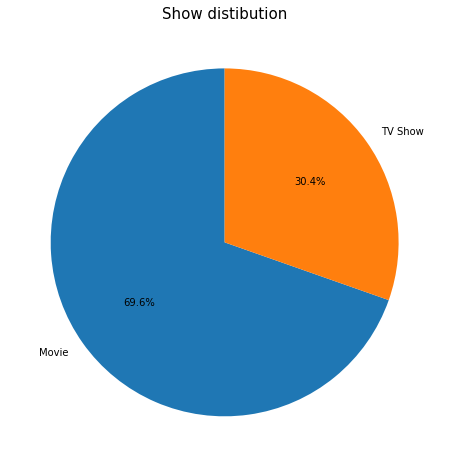

In [378]:
plt.figure(figsize=(12,8))
plt.pie(show_types,
       labels=show_types.index,
        autopct='%1.1f%%',
       startangle=90)
plt.title('Show distibution',fontsize=15)
plt.show()

**Recommendation** 

*   Based on the above graph Netflix has nearly 70% of movies and 30% of TV shows.
*   The distribution is good but Netflix can concentrate more on the TV show to import and attract the auidence. There should be a field study to made across the OTT platform to improve the contribution on the TV shows.



In [379]:
no_of_shows_released_year = netflix_df.groupby(["release_year", "type"])["show_id"].nunique().reset_index().rename({"release_year":"year", "type":"show_type", "show_id":"Count"}, axis=1)
no_of_shows_released_year

,year,show_type,Count
0,1925,TV Show,1
1,1942,Movie,2
2,1943,Movie,3
3,1944,Movie,3
4,1945,Movie,3
...,...,...,...
114,2019,TV Show,397
115,2020,Movie,517
116,2020,TV Show,436
117,2021,Movie,277


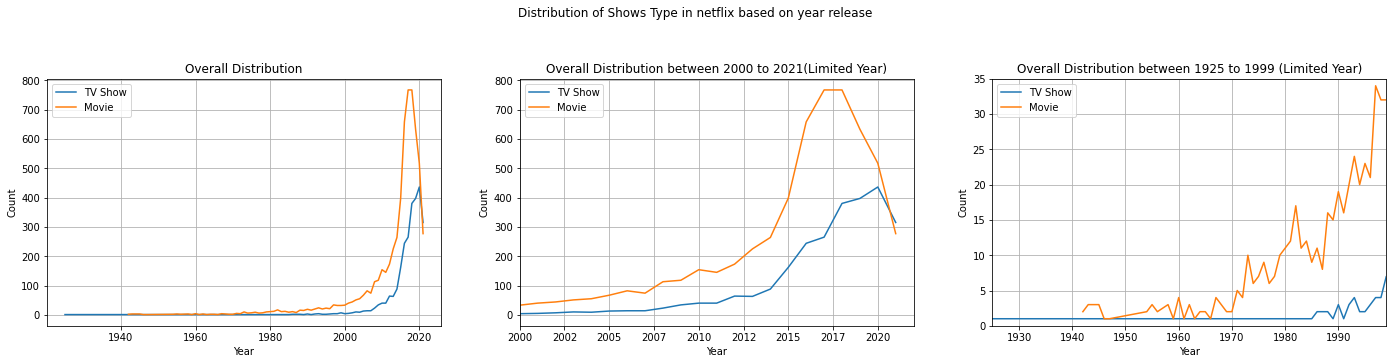

In [380]:
fig = plt.figure(figsize=(24,10))
plt.subplot(2, 3, 1)
sns.lineplot(x="year", y="Count", hue="show_type", data=no_of_shows_released_year)
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(['TV Show','Movie'])
plt.title("Overall Distribution")
plt.grid()

plt.subplot(2, 3, 2)
sns.lineplot(x="year", y="Count", hue="show_type", data=no_of_shows_released_year)
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(['TV Show','Movie'])
plt.xlim(left=2000,right=2022)
plt.title("Overall Distribution between 2000 to 2021(Limited Year)")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.grid()

plt.subplot(2, 3, 3)
sns.lineplot(x="year", y="Count", hue="show_type", data=no_of_shows_released_year)
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(['TV Show','Movie'])
plt.xlim(left=1925,right=1999)
plt.ylim(0,35)
plt.title("Overall Distribution between 1925 to 1999 (Limited Year)")
fig.suptitle('Distribution of Shows Type in netflix based on year release')
plt.grid()
plt.show()

**Recommendation on the release year**


1.   Netfix has TV shows that is released on 1925 and Movies starting from 1942
2.   Maximum Tv shows and movies was release in year 2020 and there is shrap dip in 2021 this could be due to data is limited till Sepetember month and global pandermic.
3. Also in 2021, Count of TV shows is higher than the movies.





In [381]:
no_of_shows_date_added_year = netflix_df.groupby(["date_added_year", "type"])["show_id"].nunique().reset_index().rename(
    {"date_added_year":"year", "type":"show_type", "show_id":"Count"}, axis=1)
no_of_shows_date_added_month = netflix_df.groupby(["date_added_month", "type"])["show_id"].nunique().reset_index().rename(
    {"date_added_month":"month", "type":"show_type", "show_id":"Count"}, axis=1)
no_of_shows_date_added_date = netflix_df.groupby(["date_added_date", "type"])["show_id"].nunique().reset_index().rename(
    {"type":"show_type", "show_id":"Count", "date_added_date":"date"}, axis=1)

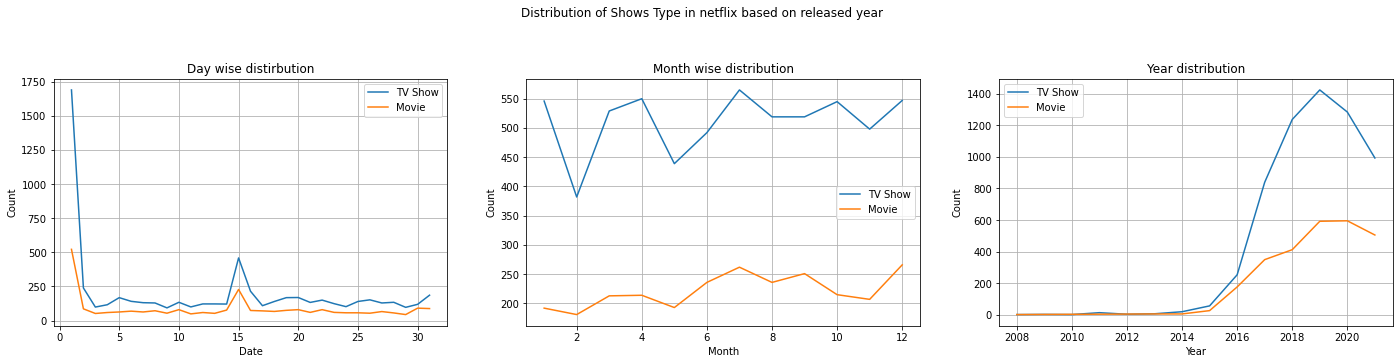

In [382]:
fig = plt.figure(figsize=(24,10))
plt.subplot(2, 3, 1)
sns.lineplot(x="date", y="Count", hue="show_type", data=no_of_shows_date_added_date)
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(['TV Show','Movie'])
plt.title("Day wise distirbution")
plt.grid()

plt.subplot(2, 3, 2)
sns.lineplot(x="month", y="Count", hue="show_type", data=no_of_shows_date_added_month)
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(['TV Show','Movie'])
plt.title("Month wise distribution")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.grid()

plt.subplot(2, 3, 3)
sns.lineplot(x="year", y="Count", hue="show_type", data=no_of_shows_date_added_year)
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(['TV Show','Movie'])
plt.title("Year distribution")
fig.suptitle('Distribution of Shows Type in netflix based on released year')
plt.grid()
plt.show()

**Insight on the Added date**


1.  Mostly TV shows & Movides are released on the 1st of every month and we have spike in mid of the month.
2. Based on the Month graph it clearly show that Netflix releasing month on July and December has some similar TV shows count.
3. No of items released on the year increasing from year, the shap inscrease is from 2015 and there is a dip in 2021.

**Actionable items**


1.   Improve the TV shows count.
2.   Widely spread the release and have more releases on the occasions.



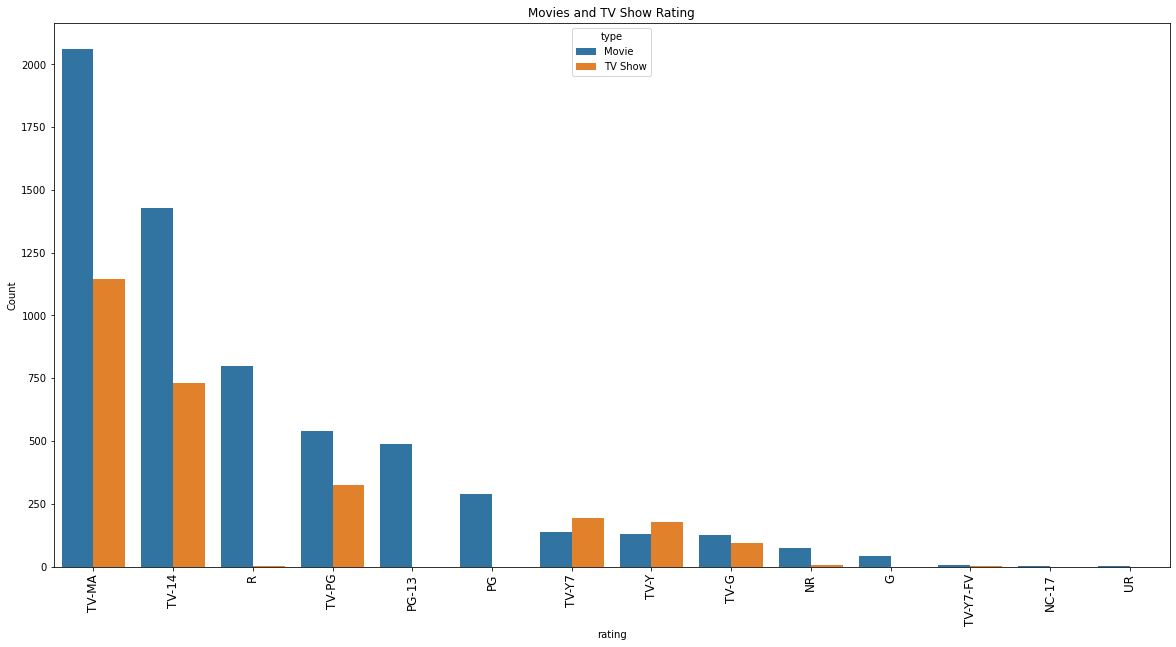

In [383]:
plt.figure(figsize=(20,10))
rating_df = netflix_df.groupby(["rating", "type"])["show_id"].nunique().reset_index().rename({"show_id":"Count"}, axis=1).sort_values(by =["type",'Count', 'rating'], ascending=[True, False, True])
sns.barplot(x="rating", y="Count", hue="type", data=rating_df)
plt.xticks(rotation=90, fontsize=12)
plt.title("Movies and TV Show Rating")
plt.show()

### Countries with Most Content

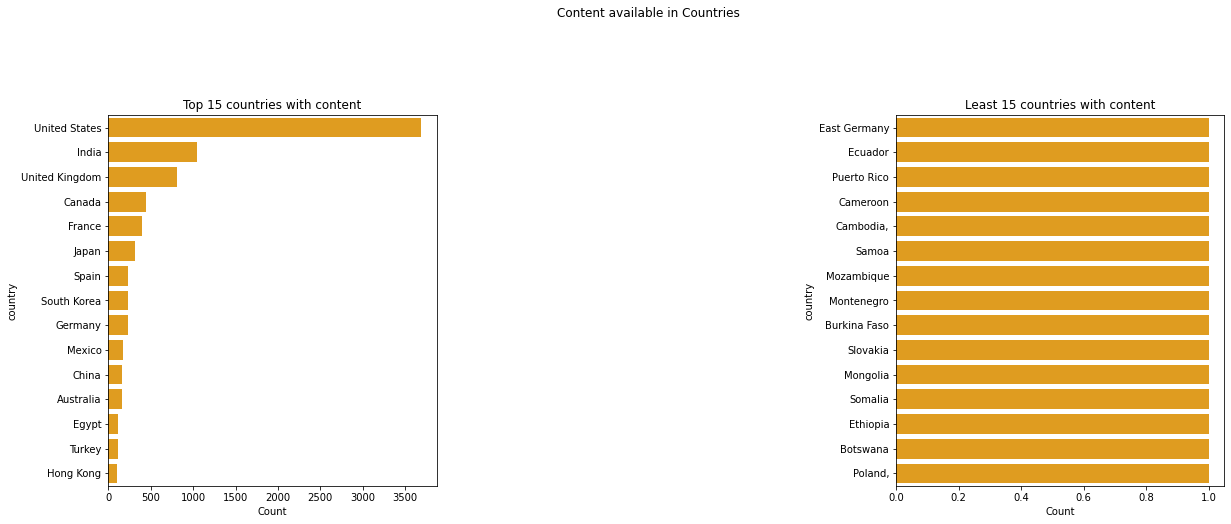

In [384]:
coutnries_df = netflix_df.groupby(["country"])["show_id"].nunique().reset_index().rename({"show_id":"Count"}, axis=1).sort_values(by =['Count'], ascending=[False])
coutnries_df = coutnries_df[~(coutnries_df["country"].str.fullmatch("nan"))]

fig = plt.figure(figsize=(20,15))
plt.subplot(2, 3, 1.5)
sns.barplot(y="country", x="Count", data=coutnries_df.head(15), color="orange")
plt.title("Top 15 countries with content")

plt.subplot(2, 3, 3)
sns.barplot(y="country", x="Count", data=coutnries_df.tail(15), color="orange")
plt.title("Least 15 countries with content")

fig.suptitle('Content available in Countries')
plt.show()

### Top Actors

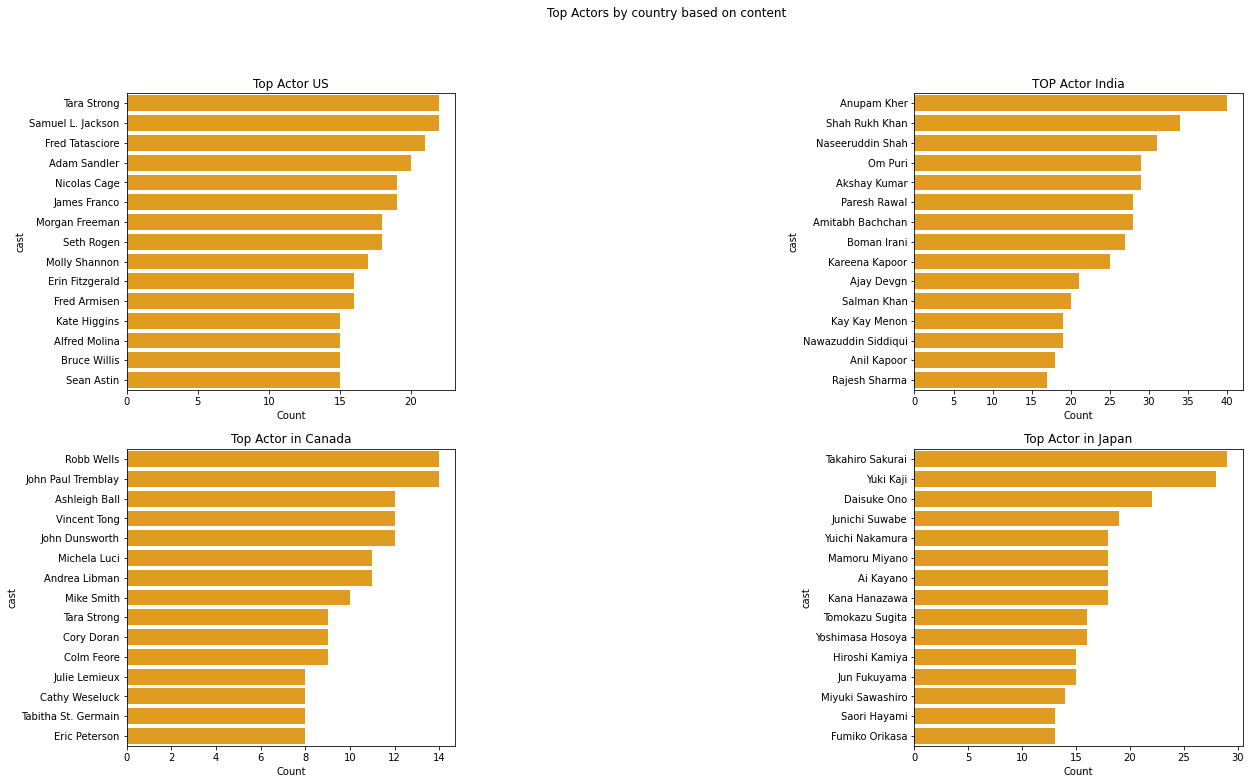

In [385]:
top_actor_df = netflix_df.groupby(["cast", "country"])["show_id"].nunique().reset_index().rename({"show_id":"Count"}, axis=1).sort_values(by =['Count'], ascending=[False])
top_actor_df = top_actor_df[~(top_actor_df["cast"].str.fullmatch("nan") | top_actor_df["country"].str.fullmatch("nan"))]

fig = plt.figure(figsize=(20,12))
plt.subplot(2, 3, 1)

sns.barplot(y="cast", x="Count", data=top_actor_df[top_actor_df["country"].str.fullmatch("United States")].head(15), color="orange")
plt.title("Top Actor US")

plt.subplot(2, 3, 3)
sns.barplot(y="cast", x="Count", data=top_actor_df[top_actor_df["country"].str.fullmatch("India")].head(15), color="orange")
plt.title("TOP Actor India")

plt.subplot(2, 3, 4)
sns.barplot(y="cast", x="Count", data=top_actor_df[top_actor_df["country"].str.fullmatch("Canada")].head(15), color="orange")
plt.title("Top Actor in Canada")

plt.subplot(2, 3, 6)
sns.barplot(y="cast", x="Count", data=top_actor_df[top_actor_df["country"].str.fullmatch("Japan")].head(15), color="orange")
plt.title("Top Actor in Japan")

fig.suptitle('Top Actors by country based on content')
plt.show()

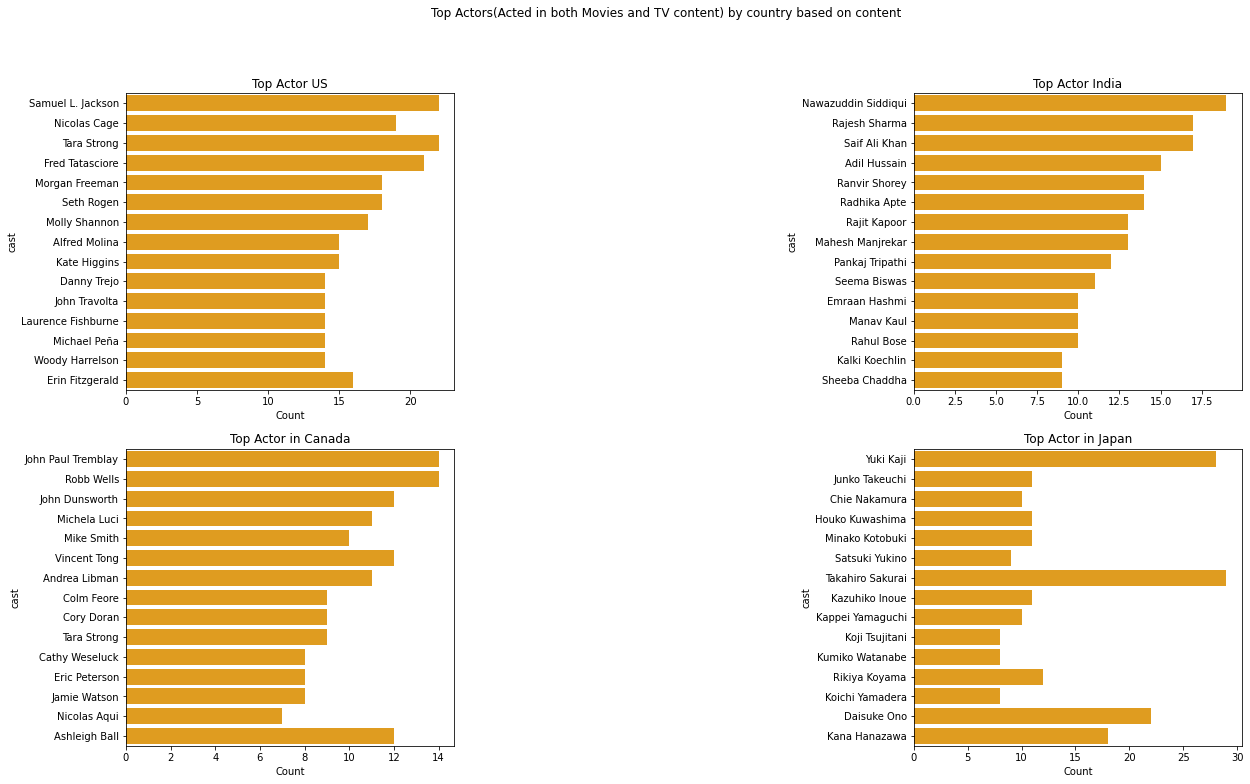

In [386]:
top_actor_df = netflix_df.groupby(["cast", "country", "type"])["show_id"].nunique().reset_index().rename({"show_id":"Count"}, axis=1).sort_values(by =['Count'], ascending=[False])
top_actor_df = top_actor_df[(~(top_actor_df["cast"].str.fullmatch("nan") | top_actor_df["country"].str.fullmatch("nan")))]
top_actor_df = pd.pivot_table(top_actor_df,index=["cast","country"], columns="type", values="Count", aggfunc='sum', margins=True, margins_name='Count').reset_index()
top_actor_df = top_actor_df[~(top_actor_df["Movie"].isna() | top_actor_df["TV Show"].isna())].sort_values(by=["country", "Movie", "TV Show"], ascending=[True,False, False])

fig = plt.figure(figsize=(20,12))
plt.subplot(2, 3, 1)

sns.barplot(y="cast", x="Count", data=top_actor_df[top_actor_df["country"].str.fullmatch("United States")].head(15), color="orange")
plt.title("Top Actor US")

plt.subplot(2, 3, 3)
sns.barplot(y="cast", x="Count", data=top_actor_df[top_actor_df["country"].str.fullmatch("India")].head(15), color="orange")
plt.title("Top Actor India")

plt.subplot(2, 3, 4)
sns.barplot(y="cast", x="Count", data=top_actor_df[top_actor_df["country"].str.fullmatch("Canada")].head(15), color="orange")
plt.title("Top Actor in Canada")

plt.subplot(2, 3, 6)
sns.barplot(y="cast", x="Count", data=top_actor_df[top_actor_df["country"].str.fullmatch("Japan")].head(15), color="orange")
plt.title("Top Actor in Japan")

fig.suptitle('Top Actors(Acted in both Movies and TV content) by country based on content')
plt.show()

### Top Directors

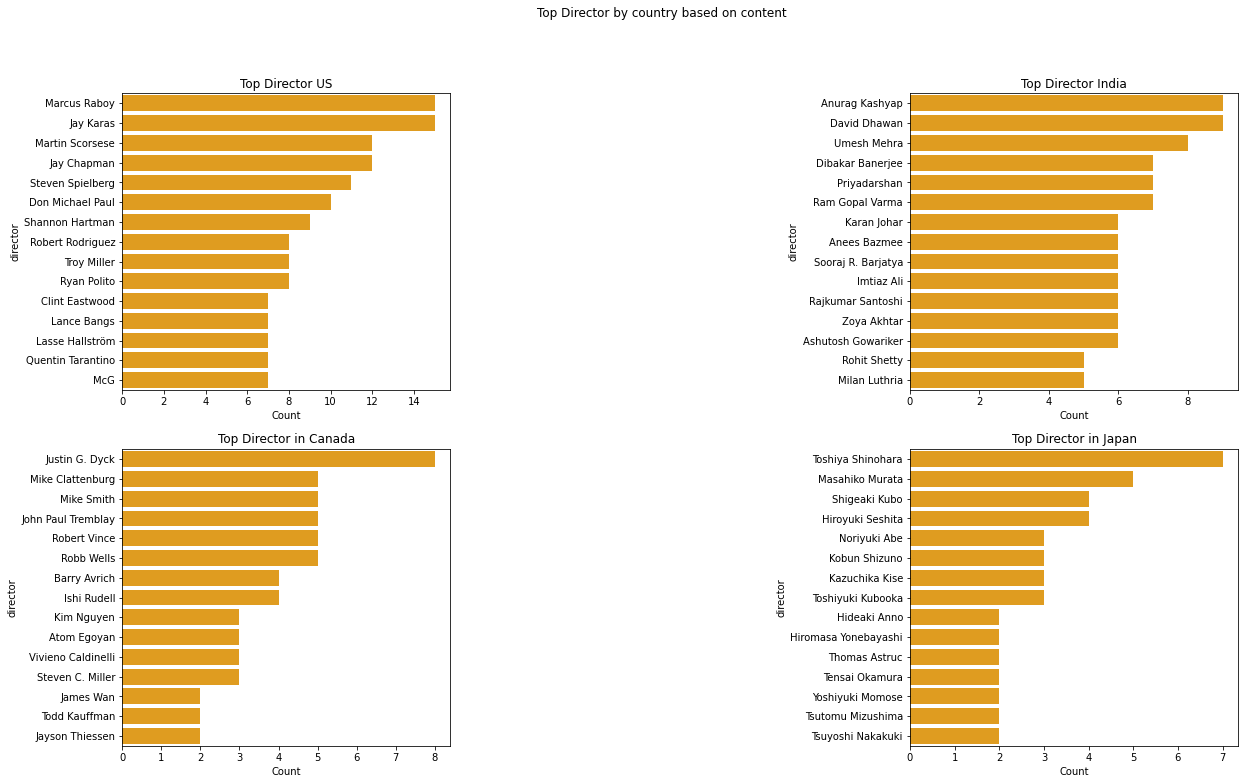

In [387]:
top_director_df = netflix_df.groupby(["director", "country"])["show_id"].nunique().reset_index().rename({"show_id":"Count"}, axis=1).sort_values(by =['Count'], ascending=[False])
top_director_df = top_director_df[~(top_director_df["director"].str.fullmatch("nan") | top_director_df["country"].str.fullmatch("nan"))]

fig = plt.figure(figsize=(20,12))
plt.subplot(2, 3, 1)

sns.barplot(y="director", x="Count", data=top_director_df[top_director_df["country"].str.fullmatch("United States")].head(15), color="orange")
plt.title("Top Director US")

plt.subplot(2, 3, 3)
sns.barplot(y="director", x="Count", data=top_director_df[top_director_df["country"].str.fullmatch("India")].head(15), color="orange")
plt.title("Top Director India")

plt.subplot(2, 3, 4)
sns.barplot(y="director", x="Count", data=top_director_df[top_director_df["country"].str.fullmatch("Canada")].head(15), color="orange")
plt.title("Top Director in Canada")

plt.subplot(2, 3, 6)
sns.barplot(y="director", x="Count", data=top_director_df[top_director_df["country"].str.fullmatch("Japan")].head(15), color="orange")
plt.title("Top Director in Japan")

fig.suptitle('Top Director by country based on content')
plt.show()

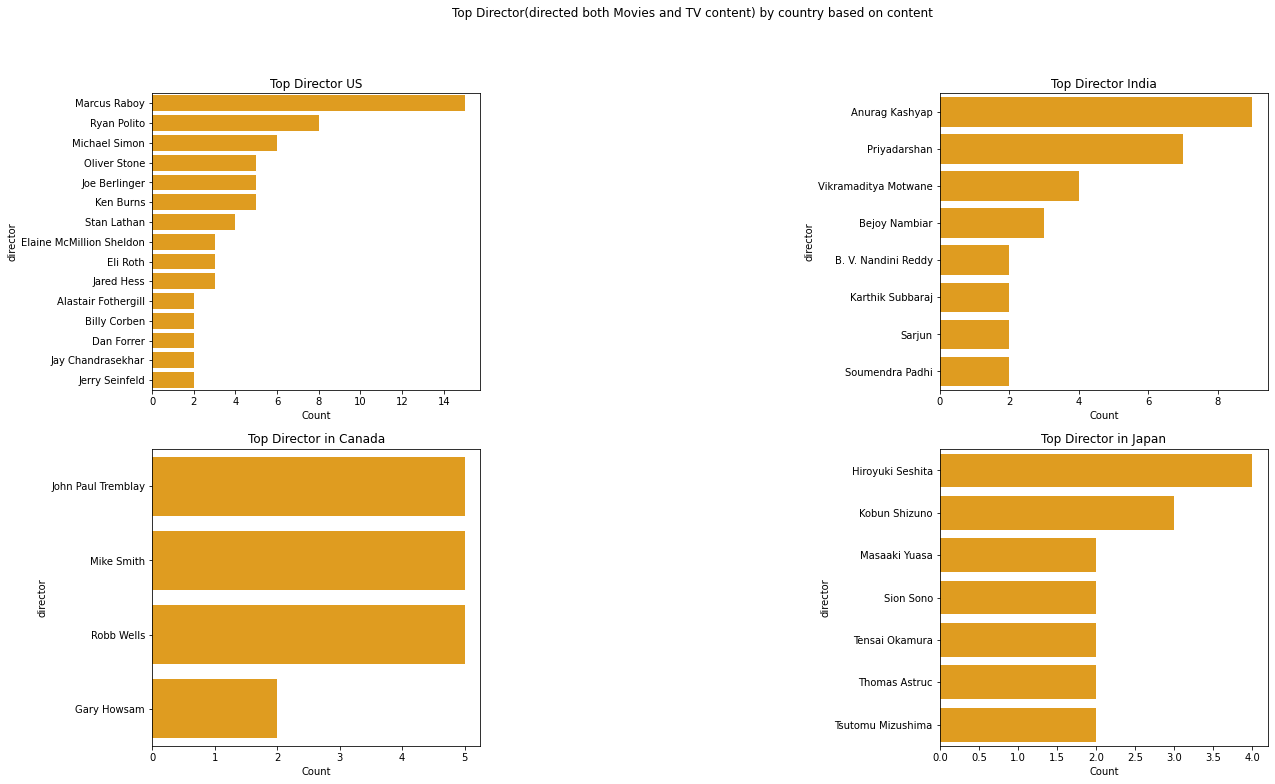

In [388]:
top_director_df = netflix_df.groupby(["director", "country", "type"])["show_id"].nunique().reset_index().rename({"show_id":"Count"}, axis=1).sort_values(by =['Count'], ascending=[False])
top_director_df = top_director_df[(~(top_director_df["director"].str.fullmatch("nan") | top_director_df["country"].str.fullmatch("nan")))]
top_director_df = pd.pivot_table(top_director_df,index=["director","country"], columns="type", values="Count", aggfunc='sum', margins=True, margins_name='Count').reset_index()
top_director_df = top_director_df[~(top_director_df["Movie"].isna() | top_director_df["TV Show"].isna())].sort_values(by=["country", "Movie", "TV Show"], ascending=[True,False, False])

fig = plt.figure(figsize=(20,12))
plt.subplot(2, 3, 1)

sns.barplot(y="director", x="Count", data=top_director_df[top_director_df["country"].str.fullmatch("United States")].head(15), color="orange")
plt.title("Top Director US")

plt.subplot(2, 3, 3)
sns.barplot(y="director", x="Count", data=top_director_df[top_director_df["country"].str.fullmatch("India")].head(15), color="orange")
plt.title("Top Director India")

plt.subplot(2, 3, 4)
sns.barplot(y="director", x="Count", data=top_director_df[top_director_df["country"].str.fullmatch("Canada")].head(15), color="orange")
plt.title("Top Director in Canada")

plt.subplot(2, 3, 6)
sns.barplot(y="director", x="Count", data=top_director_df[top_director_df["country"].str.fullmatch("Japan")].head(15), color="orange")
plt.title("Top Director in Japan")

fig.suptitle('Top Director(directed both Movies and TV content) by country based on content')
plt.show()

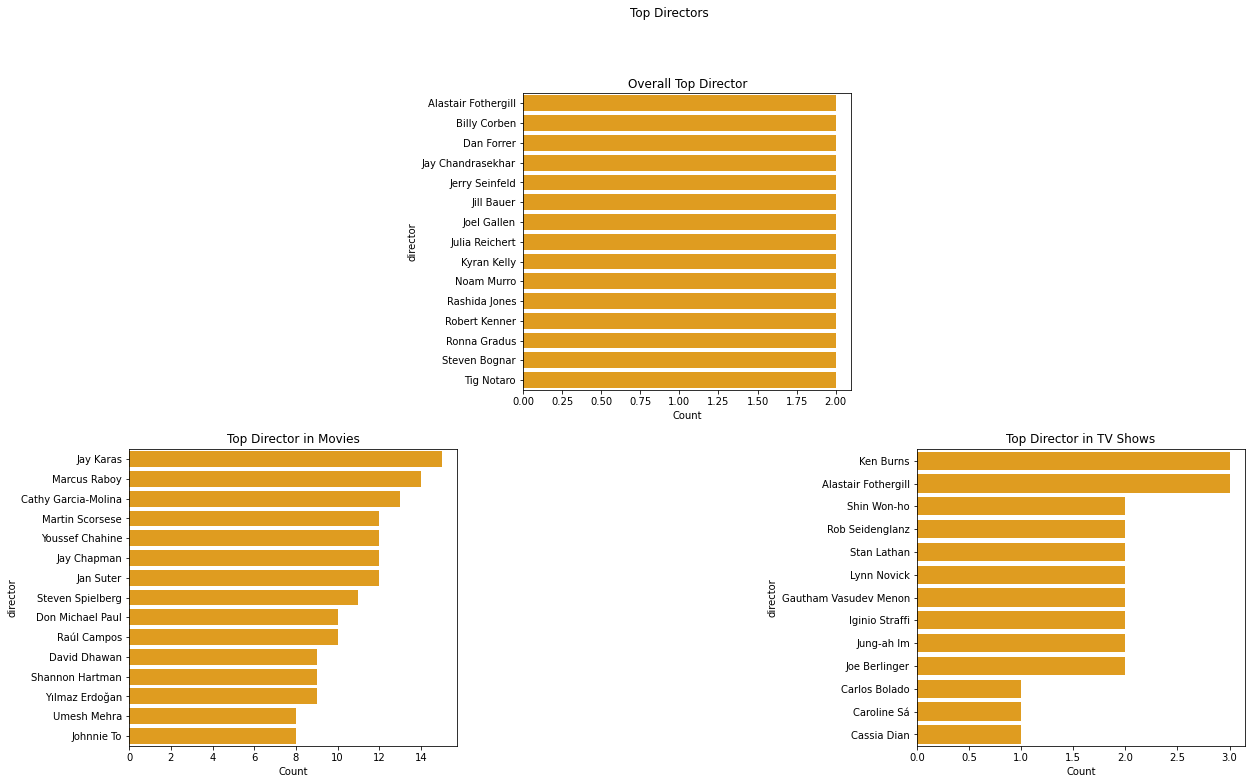

In [389]:
top_director_df = netflix_df.groupby(["director", "country", "type"])["show_id"].nunique().reset_index().rename({"show_id":"Count"}, axis=1).sort_values(by =['Count'], ascending=[False])
top_director_df = top_director_df[(~(top_director_df["director"].str.fullmatch("nan") | top_director_df["country"].str.fullmatch("nan")))]
overall_top_director_df = pd.pivot_table(top_director_df,index=["director","country"], columns="type", values="Count", aggfunc='sum', margins=True, margins_name='Count').reset_index()
overall_top_director_df = overall_top_director_df[~(overall_top_director_df["Movie"].isna() | overall_top_director_df["TV Show"].isna())].sort_values(by=["Count","country", "Movie", "TV Show"], ascending=[True,False, False, True])

fig = plt.figure(figsize=(20,12))
plt.subplot(2, 3, 2)

sns.barplot(y="director", x="Count", data=overall_top_director_df.head(15), color="orange")
plt.title("Overall Top Director")

plt.subplot(2, 3, 4)
sns.barplot(y="director", x="Count", data=top_director_df[top_director_df["type"].str.fullmatch("Movie")].sort_values(by="Count", ascending=False).head(15), color="orange")
plt.title("Top Director in Movies")

plt.subplot(2, 3, 6)
sns.barplot(y="director", x="Count", data=top_director_df[top_director_df["type"].str.fullmatch("TV Show")].sort_values(by="Count", ascending=False).head(15), color="orange")
plt.title("Top Director in TV Shows")

fig.suptitle('Top Directors')
plt.show()

### Date based analysis

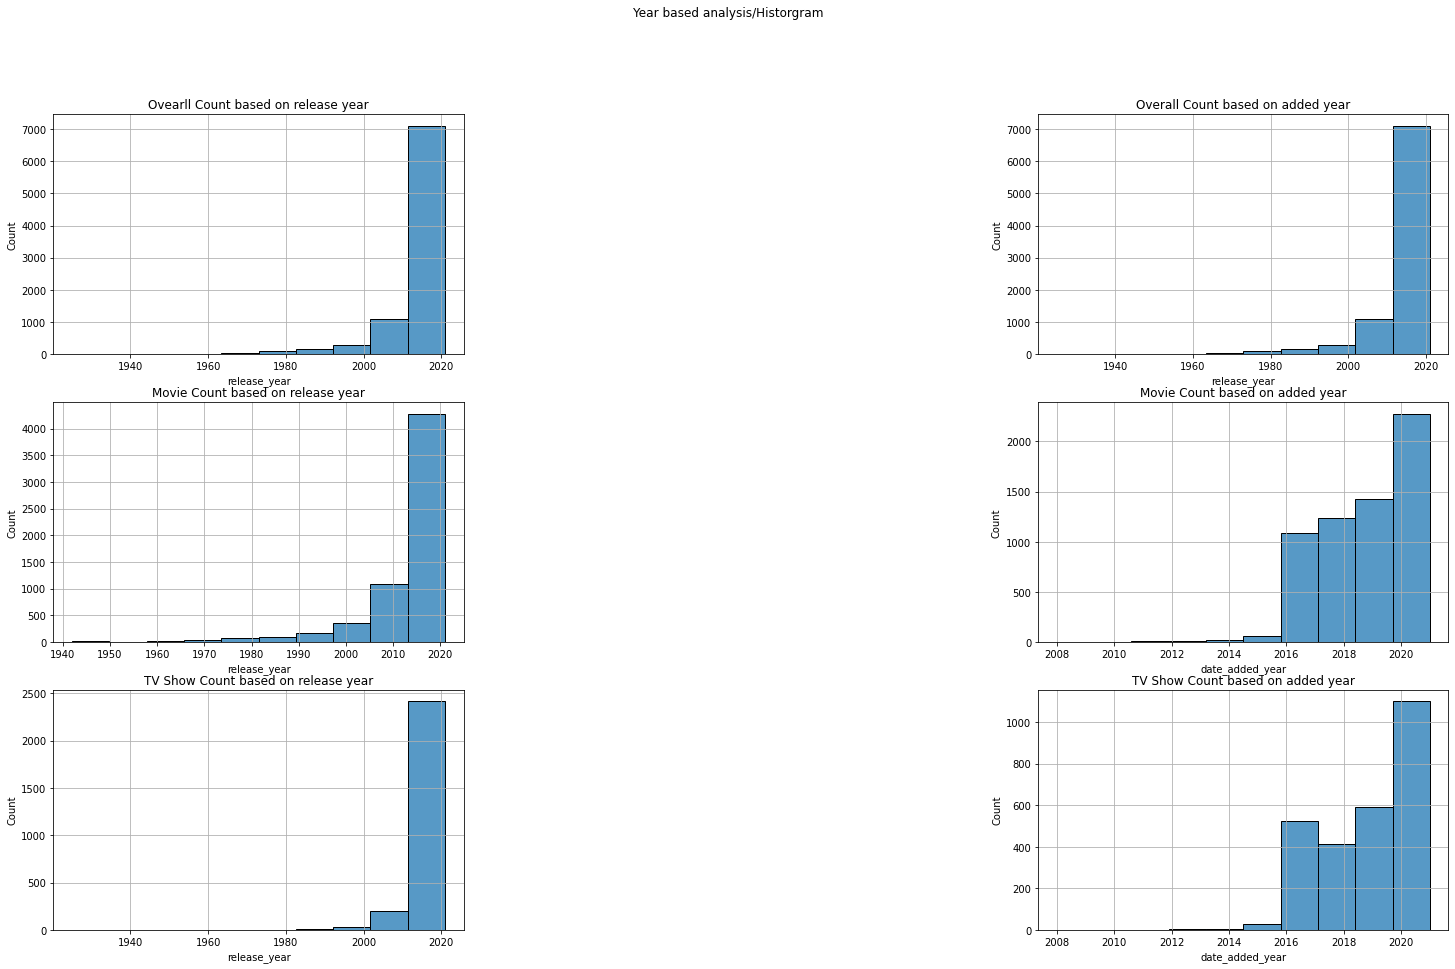

In [390]:
df["year_diff"]=df["date_added_year"]-df["release_year"]

fig = plt.figure(figsize=(25,15))
plt.subplot(3, 3, 1)
plt.grid()
sns.histplot(df['release_year'], bins=10)
plt.title("Ovearll Count based on release year")

plt.subplot(3, 3, 3)
plt.grid()
sns.histplot(df['release_year'], bins=10)
plt.title("Overall Count based on added year")

plt.subplot(3, 3, 4)
plt.grid()
sns.histplot(df[df["type"].str.fullmatch("Movie")]['release_year'], bins=10)
plt.title("Movie Count based on release year")

plt.subplot(3, 3, 6)
plt.grid()
sns.histplot(df[df["type"].str.fullmatch("Movie")]['date_added_year'], bins=10)
plt.title("Movie Count based on added year")

plt.subplot(3, 3, 7)
plt.grid()
sns.histplot(df[df["type"].str.fullmatch("TV Show")]['release_year'], bins=10)
plt.title("TV Show Count based on release year")

plt.subplot(3, 3, 9)
plt.grid()
sns.histplot(df[df["type"].str.fullmatch("TV Show")]['date_added_year'], bins=10)
plt.title("TV Show Count based on added year")

fig.suptitle('Year based analysis/Historgram')
plt.show()

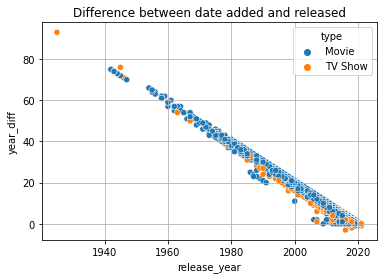

In [391]:
plt.grid()
sns.scatterplot(data=df, y='year_diff', x='release_year', hue="type")
plt.title("Difference between date added and released")
plt.show()

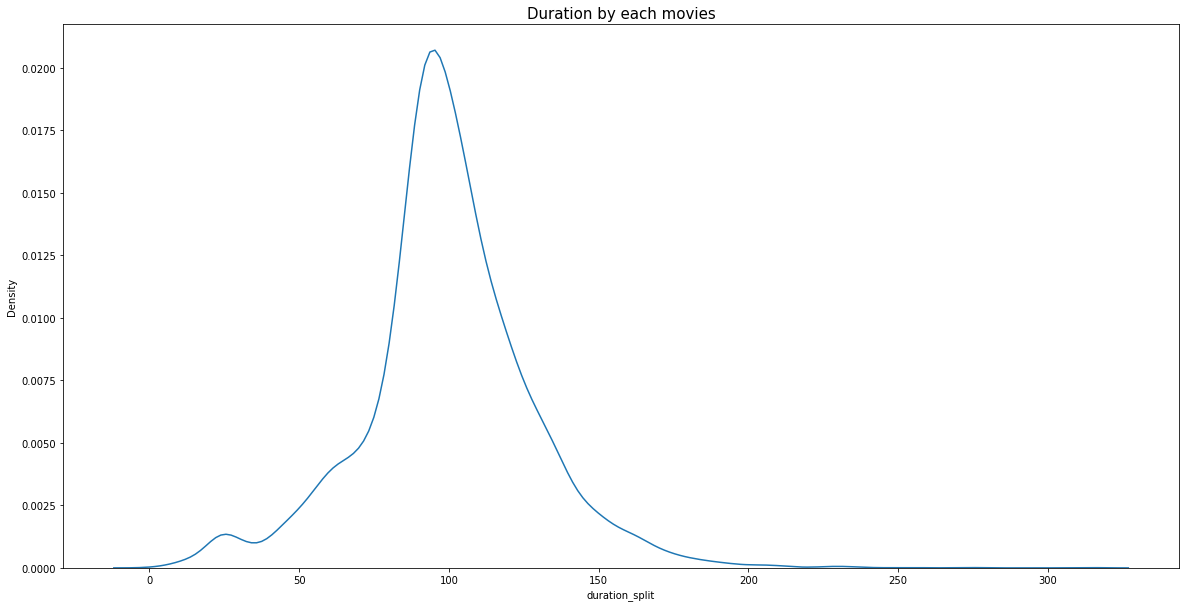

In [402]:
plt.figure(figsize=(20,10))
df["duration_split"] = df.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else 0, axis = 1)
df['season_count'] = df.apply(lambda x : x['duration'].split(" ")[0] if "Season" in x['duration'] else 0, axis = 1)

df['duration_split']=df['duration_split'].astype(str).astype(int)

sns.kdeplot(data=df[df["type"]=="Movie"]['duration_split'])
plt.title('Duration by each movies', fontsize=15)
plt.show()


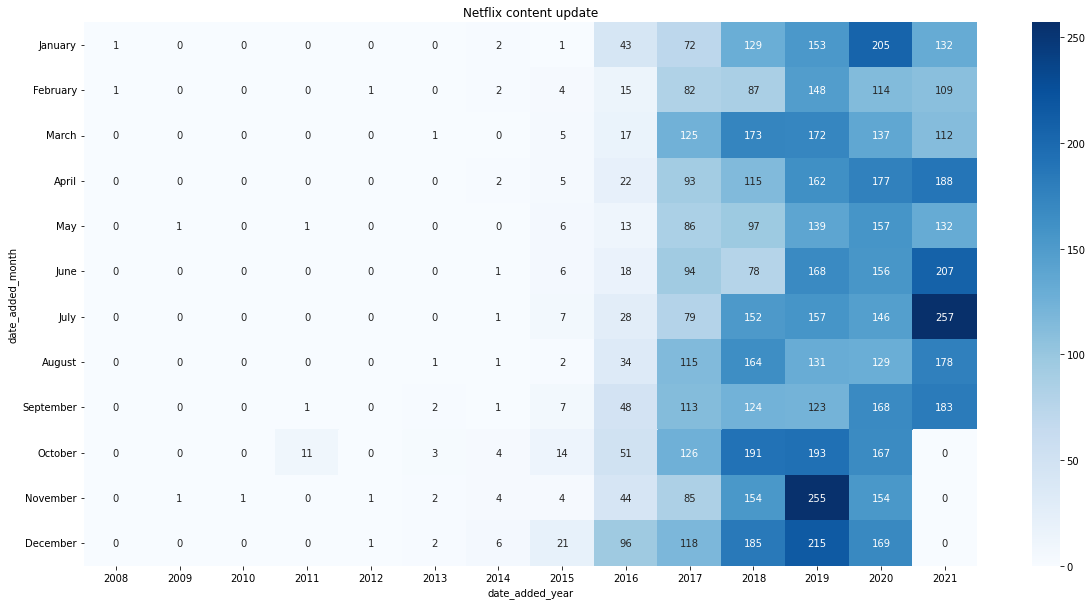

In [430]:
plt.figure(figsize=(20,10))
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
date_df = df[['date_added']].dropna()
date_df["date_added_year"] = pd.to_numeric(date_df["date_added"].dt.strftime('%Y'), downcast='signed')
date_df["date_added_month"] = date_df["date_added"].dt.strftime('%B')
df_result = date_df.groupby('date_added_year')['date_added_month'].value_counts().unstack().fillna(0)[month_order].T
sns.heatmap(df_result, cmap= "Blues", annot=True, fmt='g')
plt.title("Netflix content update")
plt.show()

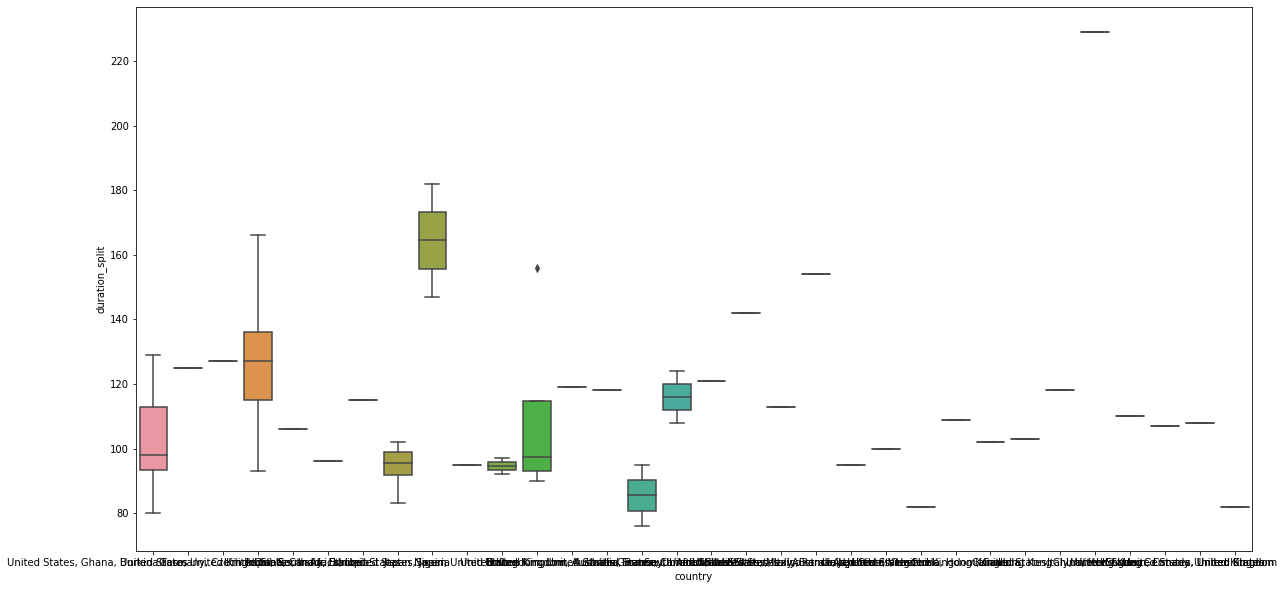

In [441]:
plt.figure(figsize=(20,10))
df["duration_split"] = df.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else 0, axis = 1)
df['season_count'] = df.apply(lambda x : x['duration'].split(" ")[0] if "Season" in x['duration'] else 0, axis = 1)

df['duration_split']=df['duration_split'].astype(str).astype(int)

sns.boxplot(x='country', y='duration_split', data=df[df["type"]=="Movie"].head(150))
plt.show()

<Figure size 1440x720 with 0 Axes>

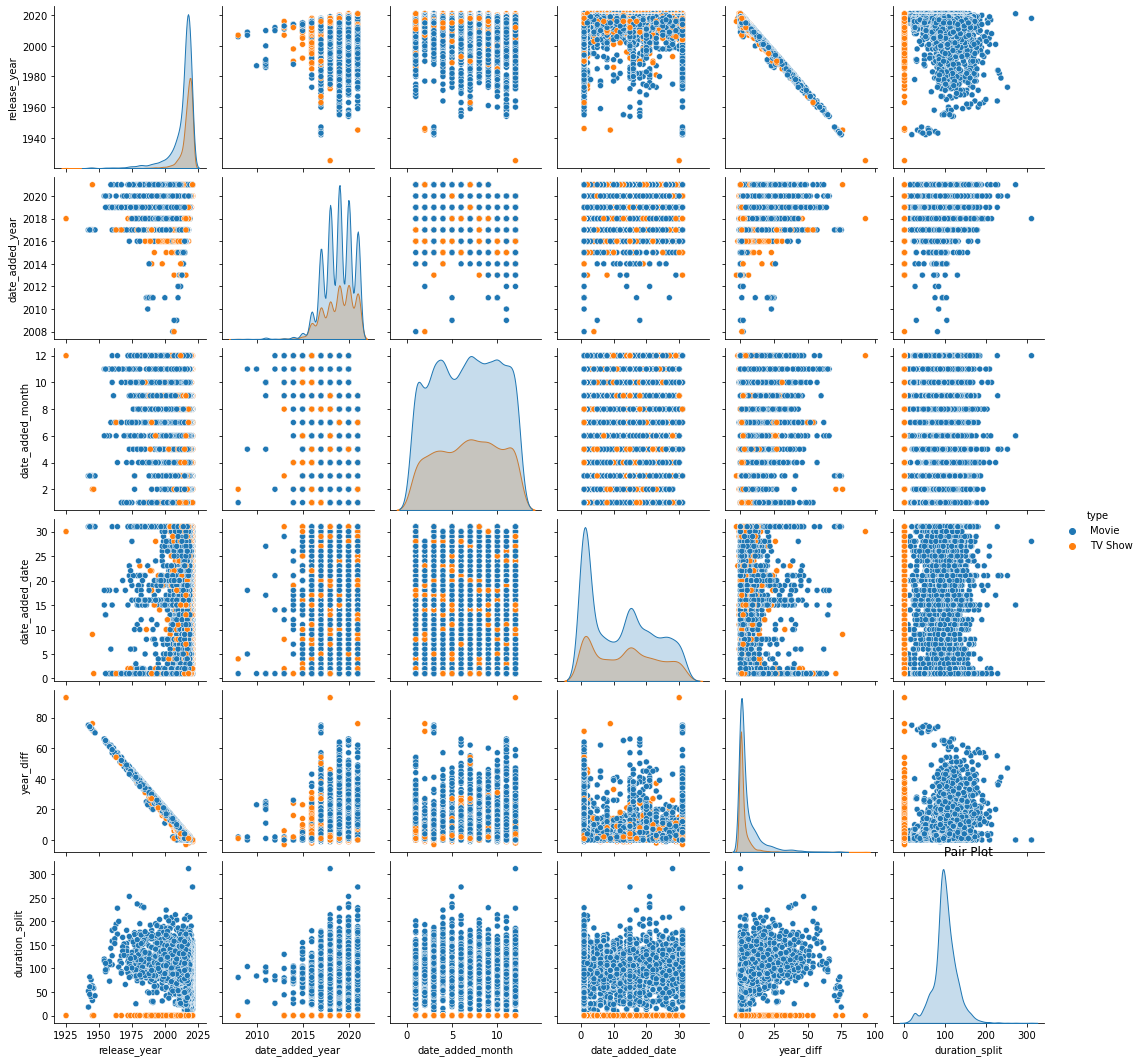

In [444]:
plt.figure(figsize=(20,10))
sns.pairplot(df, hue='type')
plt.title("Pair Plot")
plt.show()

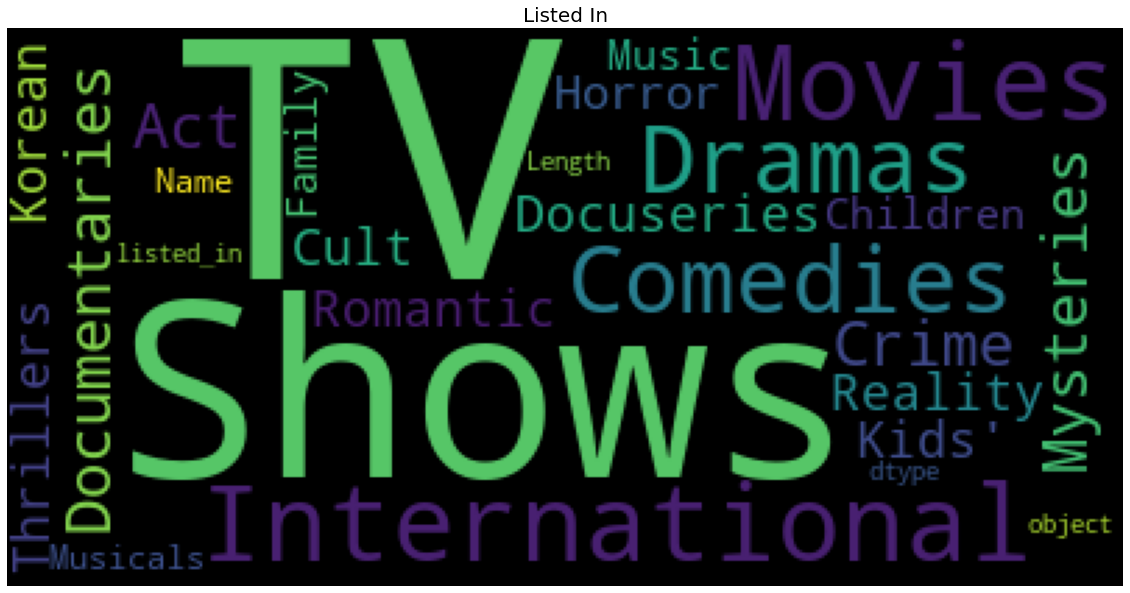

In [450]:
plt.figure(figsize = (20,20))
wordcloud = WordCloud(
                      background_color = 'black',
                      max_words = 10000,
                      max_font_size = 120,
                      random_state = 42
                    ).generate(str(df['listed_in']))

plt.imshow(wordcloud)
plt.title("Listed In", fontsize = 20)
plt.axis('off')
plt.show()

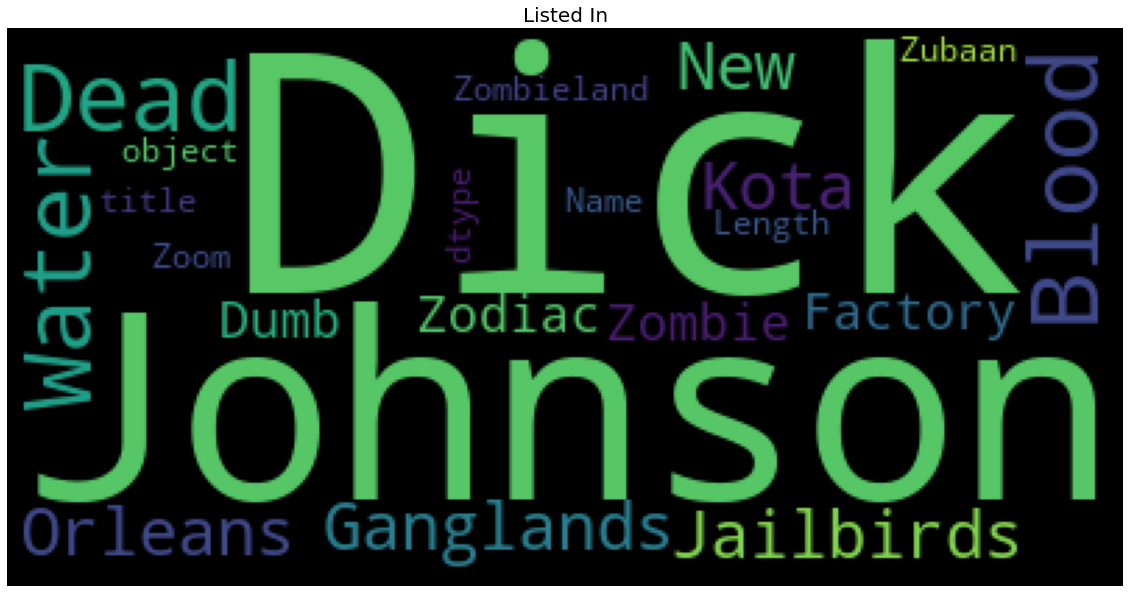

In [451]:
plt.figure(figsize = (20,20))
wordcloud = WordCloud(
                      background_color = 'black',
                      max_words = 10000,
                      max_font_size = 120,
                      random_state = 42
                    ).generate(str(df['title']))

plt.imshow(wordcloud)
plt.title("Listed In", fontsize = 20)
plt.axis('off')
plt.show()